# Generate Gaussian Samples

## Positive Samples

We are going to demostrate the RBF network for 3 dimensional Guassian distribution.

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.set_option("display.max_rows",15)
import matplotlib.pyplot as plt
import math
import sys
%matplotlib inline

In [2]:
class hp:
    n = 100
    f = 2

train_mean = np.full(shape=(hp.f), fill_value = 0)
train_var = [[1,0.6],[0.2,3]]
train_var = np.matmul(train_var, np.transpose(train_var)) # To make sure that the covariance matrix in positive semi-definate

test_mean_1 = np.full(shape=(hp.f), fill_value = 0.5)
test_var_1 = [[1,1.6],[0.6,2]]
test_var_1 = np.matmul(test_var_1, np.transpose(test_var_1))

test_mean_2 = np.full(shape=(hp.f), fill_value = 10)
test_var_2 = [[1,0.6],[2.2,3]]
test_var_2 = np.matmul(test_var_2, np.transpose(test_var_2))

test_mean_3 = np.full(shape=(hp.f), fill_value = 20)
test_var_3 = [[1,0.6],[0.2,3]]
test_var_3 = np.matmul(test_var_3, np.transpose(test_var_3))


class Dataset:
    train_positive = pd.DataFrame(
        np.random.multivariate_normal(mean=train_mean, cov=train_var, size = hp.n))
    
    test_negative_1 = pd.DataFrame(
        np.random.multivariate_normal(mean=test_mean_1, cov=test_var_1, size = hp.n))
    
    test_negative_2 = pd.DataFrame(
        np.random.multivariate_normal(mean=test_mean_2, cov=test_var_2, size = hp.n))
    
    test_negative_3 = pd.DataFrame(
        np.random.multivariate_normal(mean=test_mean_3, cov=test_var_3, size = hp.n))
    

## Negative Samples

In [3]:
Dataset.train_positive

,0,1
0,-0.400154,-1.397603
1,2.538290,3.850112
2,2.332805,1.619976
3,-0.309522,-3.706142
4,0.352531,-1.210159
5,-0.432185,0.392020
6,0.871336,1.875021
...,...,...
93,0.716024,2.519419
94,-0.578002,2.011804


Training Data (Normal)

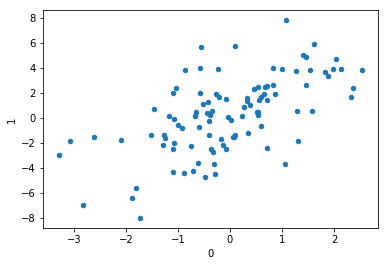

In [4]:
Dataset.train_positive.plot.scatter(x=0, y=1)

Testing Data 1 (Anamoly)

Similar Mean Different Variation

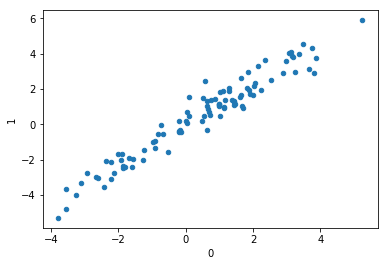

In [5]:
Dataset.test_negative_1.plot.scatter(x=0, y=1)

Testing Data 2 (Anamoly)

Different Mean Different Variation

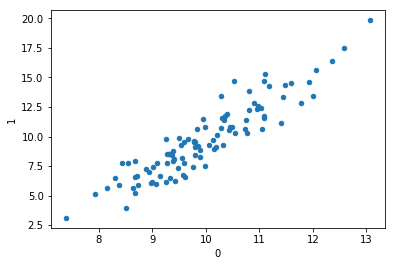

In [6]:
Dataset.test_negative_2.plot.scatter(x=0, y=1)

Testing Data 3 (Anamoly)

Different Mean similar Variation 

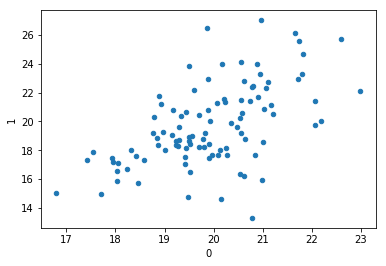

In [7]:
Dataset.test_negative_3.plot.scatter(x=0, y=1)

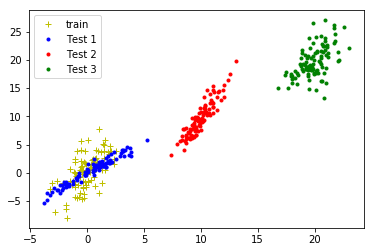

In [8]:
plt.plot(Dataset.train_positive[0], Dataset.train_positive[1], 'y+', label='train')

plt.plot(Dataset.test_negative_1[0], Dataset.test_negative_1[1], 'b.', label='Test 1')
plt.plot(Dataset.test_negative_2[0], Dataset.test_negative_2[1], 'r.', label='Test 2')
plt.plot(Dataset.test_negative_3[0], Dataset.test_negative_3[1], 'g.', label='Test 3')
plt.legend()

In [9]:


class network:
    
    params = {}
    
    def __init__(self):
        self.X = tf.placeholder(tf.float32, [hp.n, hp.f]) #hp.n, hp.f
        
    def get_cost(self, U, Z): #U, Q, Q_, Z
        
        #inverse_regularizer = tf.pow((tf.matmul(Q, Q_) - tf.eye(hp.f)), 2)
        cost = - (-U - tf.log(Z)) #+ tf.reduce_sum(inverse_regularizer)) # get -ve log likelihood
        
        #self.params.update({'U_':tf.reduce_mean(U)}) #, 'ir': tf.reduce_sum(inverse_regularizer)
        return tf.reduce_mean(cost)
    
    def get_optimizer(self):
        
        n = hp.n
        f = hp.f
        
        X = self.X
        
        P = tf.Variable(tf.truncated_normal([f]))
        Q_ = tf.Variable(tf.truncated_normal([f])) # [f,f]
        #Q_ = tf.Variable(tf.truncated_normal([f,f]))

        Q = tf.diag(tf.square(Q_)) + tf.eye(f) #tf.matmul(Q_, tf.transpose(Q_)) 
        
        M = P - tf.matmul(X, Q)
        print('M', M.get_shape())
        
        R = tf.matmul(M, Q)
        print('R', R.get_shape())
        
        V = tf.matmul(R, tf.transpose(M))
        print('V', V.get_shape())
        
        U = tf.reduce_sum(V, axis = 1, keepdims = True)
        print('U', U.get_shape())
        
        Q_det = tf.matrix_determinant(Q)
        print('Q_det', Q_det.get_shape())
        
        Z = tf.pow(tf.multiply(tf.pow(2*math.pi,f), Q_det), 1/2)
        print('Z', Z.get_shape())
        
        Y_ = tf.divide(tf.exp(-U/2), Z)
        print("Y_", Y_.get_shape())
        
        loss = self.get_cost(U, Z) # 1- Y_[0]
        train = tf.train.AdamOptimizer(0.01).minimize(loss)
        
        self.params.update({'U': U, 'M':M, 'R':R, 'Z':Z, 'Q_det':Q_det}) #  
        
        return train, loss, Y_, self.params


In [10]:
epochs = 1000
net = network()
loss_arr = []
Dataset.Y_ = []

output_tensors = net.get_optimizer()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        
        X = np.reshape(Dataset.train_positive.values, (hp.n, -1))
        
        #for i in range(X.shape[0]):
        #x = X#[i,:].reshape((1,-1))
        try:
            train, loss, Y_, params = sess.run(output_tensors, feed_dict={net.X:X})
        except tf.errors.InvalidArgumentError as e:
            #print(e)
            pass

        print("epoch", epoch, "loss", loss)#, 'U', params['U'], 'Z', params['Z']) #, 'IR', params['ir'], 'Z', params['Z'], 'U', params['U']
        loss_arr.append(loss)
            

        if(np.abs(loss) < 0.1):
            break
    Dataset.Y_.append(Y_)

M (100, 2)
R (100, 2)
V (100, 100)
U (100, 1)
Q_det ()
Z ()
Y_ (100, 1)
epoch 0 loss 367.3882
epoch 1 loss 356.4902
epoch 2 loss 345.8746
epoch 3 loss 335.54016
epoch 4 loss 325.48526
epoch 5 loss 315.70773
epoch 6 loss 306.20505
epoch 7 loss 296.97415
epoch 8 loss 288.0117
epoch 9 loss 279.31393
epoch 10 loss 270.8769
epoch 11 loss 262.6961
epoch 12 loss 254.76683
epoch 13 loss 247.08438
epoch 14 loss 239.64362
epoch 15 loss 232.43903
epoch 16 loss 225.46535
epoch 17 loss 218.71692
epoch 18 loss 212.18811
epoch 19 loss 205.87312
epoch 20 loss 199.76624
epoch 21 loss 193.86154
epoch 22 loss 188.15323
epoch 23 loss 182.63547
epoch 24 loss 177.30258
epoch 25 loss 172.14871
epoch 26 loss 167.16827
epoch 27 loss 162.35571
epoch 28 loss 157.70544
epoch 29 loss 153.21204
epoch 30 loss 148.87025
epoch 31 loss 144.67493
epoch 32 loss 140.62096
epoch 33 loss 136.70335
epoch 34 loss 132.91736
epoch 35 loss 129.25827
epoch 36 loss 125.72154
epoch 37 loss 122.30267
epoch 38 loss 118.99743
epoch 39

In [11]:
Dataset.Y_

[array([[0.15915525],
        [0.15915494],
        [0.15915464],
        [0.15915555],
        [0.15915616],
        [0.1591549 ],
        [0.15915433],
        [0.15915525],
        [0.15915486],
        [0.15915373],
        [0.15915555],
        [0.15915403],
        [0.15915479],
        [0.15915555],
        [0.15915449],
        [0.15915388],
        [0.15915555],
        [0.15915616],
        [0.15915585],
        [0.15915859],
        [0.15915479],
        [0.15915485],
        [0.15915471],
        [0.15915525],
        [0.1591557 ],
        [0.15915373],
        [0.15915251],
        [0.15915555],
        [0.15915616],
        [0.15915342],
        [0.15915585],
        [0.15915403],
        [0.15915616],
        [0.15915616],
        [0.15915498],
        [0.159155  ],
        [0.15915312],
        [0.15915403],
        [0.15915312],
        [0.15915675],
        [0.15915433],
        [0.15915494],
        [0.159155  ],
        [0.15915501],
        [0.15915312],
        [0

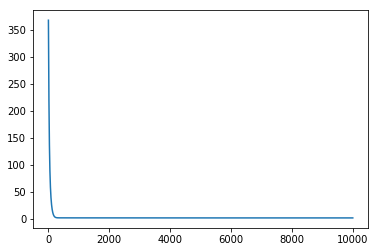

In [12]:
plt.plot(loss_arr)